# McKesson Data Science Challenge

### Leland Barnard
### 23 May 2017

In [1]:
import pandas as pd
import sqlite3
import math
import numpy as np
from collections import defaultdict
import operator
from lifelines.utils import datetimes_to_durations
from lifelines import AalenAdditiveFitter
from sklearn import base
from sklearn.pipeline import Pipeline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 144
matplotlib.rcParams['figure.figsize'] = (15, 8)
matplotlib.rcParams["font.size"] = "16"

In [3]:
%load_ext sql

/opt/conda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [4]:
mck_df = pd.read_csv('DataScienceTakeHomev2DataSet.csv',encoding='utf-8')

## Part 1: Customer data intake, compilation, and export
To better understand customer behavior, it would be useful to track the average time it takes for customers to convert to the generic drug, and the median conversion time for converted customers.  Furthermore, it would be helpful to be able to compute these statistics across different groupings of customers (i.e., by country, by first purchase date, etc.).  In the cell below, I have defined a function **getGroupStats** that accepts a DataFrame in the format of the given .csv, groups the data by a desired column, and returns a new DataFrame with the following summary statistics of the indicated groups: number of customers, conversion rate, mean conversion time in days, and median conversion time in days.  A minimum number of customers for a group, **n_min**, can also be provided. This function makes use of a custom scikit-learn transform class called **mck_df_xform_simple** that is defined and described in greater detail in Part 2 of this document.

In [117]:
def getGroupStats(df,group_key,n_min):
    
    xformer = mck_df_xform_simple()
    groups = df.groupby(group_key)
    col_dict = defaultdict(list)
    rows = []
    n_cust = []
    conv_rat = []
    median_conv_time = []
    mean_conv_time = []
    for name,group in groups:
        if len(group) >= n_min:
            X = xformer.transform(group)
            col_dict[group_key].append(name)
            col_dict['num_cust'].append(len(X))
            n_conv = float(sum(X['converted']))
            col_dict['conv_rate'].append(n_conv/len(X))
            lifetimes = X[X['converted']==True]['lifetime']
            col_dict['median_conv_time'].append(lifetimes.median())
            col_dict['mean_conv_time'].append(lifetimes.mean())
     
    return pd.DataFrame.from_dict(col_dict)[[group_key,'num_cust','conv_rate','median_conv_time','mean_conv_time']]

For example, we can examine customer data grouped by day of the week of first purchase:

In [119]:
mck_byDoW_df = getGroupStats(mck_df,'first_purchase_day_of_week', n_min = 0)
mck_byDoW_df.sort_values('conv_rate', ascending = False)

,first_purchase_day_of_week,num_cust,conv_rate,median_conv_time,mean_conv_time
0,Friday,10927,0.217535,9.0,15.669752
4,Thursday,12718,0.215679,9.0,14.847977
3,Sunday,7349,0.210777,9.0,15.560362
5,Tuesday,11078,0.210417,8.0,14.133848
6,Wednesday,14114,0.208375,9.0,15.000680
2,Saturday,6756,0.207963,7.0,14.548754
1,Monday,11949,0.186208,9.0,15.812135


or by customer country:

In [120]:
mck_byCountry_df = getGroupStats(mck_df,'cust_country', n_min = 500)
mck_byCountry_df.sort_values('num_cust', ascending = False)

,cust_country,num_cust,conv_rate,median_conv_time,mean_conv_time
10,United States,45149,0.235598,8.0,14.813387
9,United Kingdom,5408,0.205251,8.5,15.335135
2,Canada,4868,0.208710,10.0,15.224409
0,Australia,3414,0.242531,11.0,16.047101
5,India,1018,0.033399,1.5,11.970588
11,null,996,0.010040,14.0,16.400000
4,Germany,843,0.195730,10.0,15.666667
8,New Zealand,648,0.208333,10.0,13.355556
6,Ireland,617,0.110211,13.5,20.191176
7,Netherlands,567,0.178131,11.0,15.089109


With this query, it is immediately clear that conversion rates and times differ strongly between customers from different countries.  We can incorporate the function **getGroupStats** into a workflow that will allow users to quickly generate new tables based on the results of their query, either as SQL tables or .csv export.  The function in the next cell **generateGroupTable** accepts a file path to a .csv file containing the input data (**path**), arguments for the **getGroupStats** function above, a name for the output table (**outputName**), and a flag indicating either output via .csv export or SQL table creation (**outputFormat**).  If no output format is specified, the summary DataFrame is returned.

In [125]:
def generateGroupTable(path,group_key,n_min,outputName,outputFormat):
    
    df = pd.read_csv(path,encoding='utf-8')
    group_df = getGroupStats(df,group_key,n_min)
    
    if outputFormat == 'SQL':
        %sql sqlite:///testdb.sqlite
        conn = sqlite3.connect('testdb.sqlite')
        group_df.to_sql(outputName, conn, if_exists='replace',index=False)
    
    elif outputFormat == 'csv':
        fileName = './'+outputName+'.csv'
        group_df.to_csv(fileName)
        
    else:
        print 'SQL or .csv output not specified, returning DataFrame'
        return group_df

The cells below contain examples of this workflow applied to the day of week and customer country queries performed above.

In [126]:
generateGroupTable(path = 'DataScienceTakeHomev2DataSet.csv',
                   group_key = 'first_purchase_day_of_week',
                   n_min = 0,
                   outputName = 'summary_dayOfWeek',
                   outputFormat = 'SQL')

In [127]:
%%sql
SELECT *
FROM summary_dayOfWeek

Done.


first_purchase_day_of_week,num_cust,conv_rate,median_conv_time,mean_conv_time
Friday,10927,0.217534547451,9.0,15.669751788
Monday,11949,0.186208050883,9.0,15.8121348315
Saturday,6756,0.207963291889,7.0,14.5487544484
Sunday,7349,0.210776976459,9.0,15.5603615236
Thursday,12718,0.215678565812,9.0,14.8479766679
Tuesday,11078,0.210417042788,8.0,14.1338481338
Wednesday,14114,0.208374663455,9.0,15.0006800408


In [129]:
generateGroupTable(path = 'DataScienceTakeHomev2DataSet.csv',
                   group_key = 'cust_country',
                   n_min = 500,
                   outputName = 'summary_country',
                   outputFormat = 'csv')

In [132]:
mck_byCountry_df = pd.read_csv('summary_country.csv',encoding='utf-8')
mck_byCountry_df.sort_values('num_cust', ascending = False)

,Unnamed: 0,cust_country,num_cust,conv_rate,median_conv_time,mean_conv_time
10,10,United States,45149,0.235598,8.0,14.813387
9,9,United Kingdom,5408,0.205251,8.5,15.335135
2,2,Canada,4868,0.208710,10.0,15.224409
0,0,Australia,3414,0.242531,11.0,16.047101
5,5,India,1018,0.033399,1.5,11.970588
11,11,null,996,0.010040,14.0,16.400000
4,4,Germany,843,0.195730,10.0,15.666667
8,8,New Zealand,648,0.208333,10.0,13.355556
6,6,Ireland,617,0.110211,13.5,20.191176
7,7,Netherlands,567,0.178131,11.0,15.089109


## Part 2: Predicting final conversion rates
### Model overview
This task was approached from the perspective of a survival analysis, where a customer that is never converted is considered a "survivor," and the date of conversion for a customer is considered to be the "death event."  The raw output of this model is the probability as a function of time after a customer's initial purchase that they remain not converted, or "alive."  Survival analysis is a standardized and relatively common tool for predictive modeling, and it can be performed in Python using a package called [Lifelines](https://github.com/CamDavidsonPilon/lifelines/blob/master/docs/index.rst). 

The first task in building the model is to split the data into a training data set for fitting the model and a testing data set for validating the model performance.  The cell below splits the cohorts into training and testing groups based on their initial date of purchase (even dates are used for training, odd dates for testing, so that they are uniformly distributed throughout the month).

In [6]:
train_df = pd.DataFrame([])
test_df = pd.DataFrame([])
for name,group in mck_df.groupby('first_purchase_date'):
    date = int(name.split('/')[1])
    if date%2: train_df = train_df.append(group, ignore_index = True)
    else: test_df = test_df.append(group, ignore_index = True)

### Model pipeline
While Lifelines is not a part of scikit-learn, it was designed with similar workflow patterns in mind, and to make this tool modular, extendable, and familiar to scikit-learn users, I haved developed it using the scikit-learn pipeline.

First, I defined custom transformer and estimator classes based on the scikit-learn base classes:

In [7]:
class mck_df_xform_simple(base.BaseEstimator, base.RegressorMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self,mck_df):
        mck_df.loc[:,'first_purchase_date'] = mck_df.loc[:,'first_purchase_date'].apply(lambda x: pd.to_datetime(x))
        mck_df.loc[:,'cust_commit_date'] = mck_df.loc[:,'cust_commit_date'].apply(lambda x: pd.to_datetime(x))
        start_date = mck_df.loc[:,'first_purchase_date']
        end_date = mck_df.loc[:,'cust_commit_date']
        mck_df.loc[:,'lifetime'],mck_df.loc[:,'converted'] = datetimes_to_durations(start_date,end_date)
        X = mck_df.loc[:,['lifetime','converted']]
        return X

The class **mck_df_xform_simple** creates a transformer that transforms a raw DataFrame created from the given .csv file format into a DataFrame that can be used by the Lifelines survival regression module.  This is referred to as a 'simple" transformer because it does not create any features based on the customer data present in the input data (e.g., **cust_country**, **first_purchase_hour**, etc.), it simply returns a DataFrame with a column of boolean values representing whether a customer was converted or not (referred to as **'converted'**), and the column **'lifetime'** reprenting the time in days between a customer's first purchase and their conversion date (or the maximum date in the set if they were never converted).  This results in simple featureless survival regression model that considers all customers to be identical.  As will be demonstrated later, a more sophisticated model can be implemented by simply creating a new transformer that produces the desired additional features, without changing any other part of the workflow.

In [8]:
class mck_model(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,surv_regressor):
        
        self.estimator = surv_regressor
    
    def fit(self, X, y = None):
        self.estimator.fit(X, 'lifetime', event_col='converted')
        return self
    
    def predict(self,X):
        y = self.estimator.predict_survival_function(X)
        return y

The class **mck_model** creates a custom scikit-learn estimator that accepts a feature DataFrame **X** coming from a **mck_df_xform_simple** transformer and fits a survival analysis regressor from the Lifelines package if the fit method is called, or returns the estimated survival function for **X** if the predict method is called.  The predict method will return a DataFrame with *c* columns, one for each customer (represented by the rows of **X**).  The rows *r* in the returned DataFrame represent the number of days after the initial purchase date for each of the *c* customers, and the value at position (*r*,*c*) in the returned DataFrame is the probability that customer *c* will still be 'alive' or not converted after *r* days.  Here, we are using a simple model that treats all customers the same, so every customer will have identical values in each row *r*, but this will not be the case with a more complex model that will provide different estimations based on individual customer data. 

In [9]:
mck_simple_pipeline = Pipeline([
    ('transform', mck_df_xform_simple()),
    ('regressor', mck_model(AalenAdditiveFitter(coef_penalizer=1, fit_intercept=True)))
])

The scikit-learn pipeline **mck_simple_pipeline** takes in a DataFrame coming directly from the given .csv format, transforms it using the specified transformer, and then either fits a model using the specified survival regression estimator if the fit method is called or returns a prediction if the predict method is called.

We now have all the tools we need to build the model.  Below, I will train the model using the training cohorts, and then develop the necessary tools to forecast the conversion rates for the cohorts in the testing group.

In [10]:
mck_simple_pipeline.fit(train_df)

 [-----------------100%-----------------] 8000 of 8000 complete in 17.2 sec


Pipeline(steps=[('transform', mck_df_xform_simple()), ('regressor', mck_model(surv_regressor=None))])

### Workflow for forecasting final cohort conversion rates
First, let's simply compare the survival fraction predicted by the model with the actual survival fractions for the testing cohorts.  Below I have defined a function **getConversionFractions** that returns the fraction of non-converted customers as a function of the number of days following the initial purchase date for a given cohort.  This function takes in a DataFrame in the form provided by the **mck_df_xform_simple** transformer class defined above and returns a list of 150 values representing the non-converted fraction of that cohort at the end of the first 150 days following the initial purchase date.  150 days was chosen as a cutoff representing the end of a cohort, as all cohorts in the set had nearly converged to their final conversion rate by this time. 

In [11]:
def getConversionFractions(df):
    
    span = range(len(df))
    f = []
    
    for t in span:
        f.append(float(len(df[df['lifetime']>t]))/len(df))
        
    return f[:150]

In the next cell, I have created two DataFrames, one called **test_obs_df** containing the observed survival fractions for each of the cohorts in the test set (referred to as **test_df**), and one called **test_mod_df** containing the model predicted survival fractions for each test cohort.  

In [13]:
df_xformer = mck_df_xform_simple()
test_surv_obs = {}
test_surv_mod = {}
for name,group in test_df.groupby('first_purchase_date'):
    group_xform = df_xformer.transform(group)
    test_surv_obs[str(name)[:10]] = getConversionFractions(group_xform)
    test_surv_mod[str(name)[:10]] = mck_simple_pipeline.predict(group).mean(axis=1).tolist()[:150]

test_obs_df = pd.DataFrame.from_dict(test_surv_obs)
test_mod_df = pd.DataFrame.from_dict(test_surv_mod)
test_obs_df['day'] = range(1,151)
test_mod_df['day'] = range(1,151)


In the figure below, I have plotted the observed and model predicted non-converted customer fractions for all of the cohorts in the test group. 

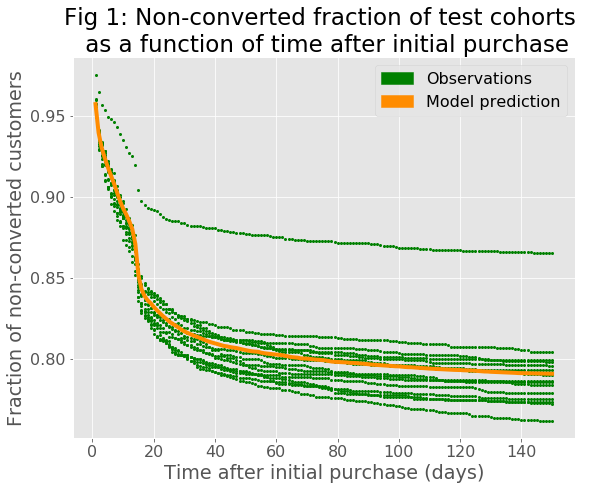

In [16]:
fig = plt.figure(figsize = (9, 7))
ax = fig.add_subplot(111)

for ch in test_surv_obs.keys():
    ax.plot(test_obs_df['day'], test_obs_df[ch], 'o', c = 'green', ms = 2)

ax.plot(test_mod_df['day'], test_mod_df['5/2/2013'], lw = 4, c = 'darkorange')

plt.xlabel('Time after initial purchase (days)')
plt.ylabel('Fraction of non-converted customers')
plt.title('Fig 1: Non-converted fraction of test cohorts \n as a function of time after initial purchase')
obs_patch = mpatches.Patch(color='green', label='Observations')
mod_patch = mpatches.Patch(color='darkorange', label='Model prediction')
plt.legend(handles=[obs_patch,mod_patch])

plt.show()

In Figure 1, we can see that the model describes the shape of the observed survival curves quite well.  Notably, there appears to be an important event that occurs at around the 14 day point where the non-converted fraction for every cohort decreases significantly before resuming a more smooth exponential decay.  Absent any other information, it seems reasonable to guess that the original purchase for this particular drug consists of a 2 week prescription, and many customer conversions occur 2 weeks later when the prescription is refilled.  There is also one cohort that is a strong outlier from the others, possibly due to features of the customer make up of this particular cohort, but the simple model that I have used here does not have any mechanism to account for this.  We will take a second look at this cohort with a more sophisticated model below.

The conversion probability of a cohort is simply the compliment of the survival probability (i.e., conversion_rate = 1-survival_rate).  Therefore, using this model to provide a prediction of the final conversion rate of a given cohort is quite straightforward.  In order to update that prediction as a cohort matures, I will make the following approximation:  the forecasted conversion rate for a cohort at any time after its initial purchase date is equal to the *observed* converted fraction of the cohort at that time, plus the difference between the *predicted* converted fraction at that time and the *predicted* final converted fraction.  In other words, at any given time, we can use the model to tell us what additional fraction of the cohort are likely to convert between that time and the final time of the cohort (defined here to be 150 days).  We then add that additional fraction to the converted fraction observed at that time to get the forecasted final converted fraction for that cohort.  

In the cell below, I have defined a function **getForecast** to perform this calculation.  This function takes in a list of observed survival fractions for a given cohort **f_meas**, a list of model predicted survival fractions for that cohort **f_pred**, and returns a list **c** of the final conversion rate for that cohort forecasted at the end of each day based on the conversion rate observed up to that day.  In other words, if a cohort is 15 days old, **c** will have 15 elements, corresponding to the forecasted final conversion rate at the end of each of the first 15 days. 

In [17]:
def getForecast(f_meas,f_pred):
    
    c = []
    f_pred_max = min(f_pred)
    
    for ind in range(len(f_meas)):
        
        c.append( 100*(1-(f_meas[ind]-(f_pred[ind]-f_pred_max))) )
        
    return c

In the next cell, I have created two DataFrames, **forecast_df** and **error_df** that contain the forecasted final conversion rates and the residual of the forecasts, respectively, at the end of each of the 150 days of the cohorts.  Here, the residual is defined as the difference between the forecasted final conversion rate and the observed conversion rate after 150 days.

In [18]:
test_forecast = {}
test_error = {}
for ch in test_surv_obs.keys():
    test_forecast[ch] = getForecast(test_obs_df[ch],test_mod_df[ch])
    test_error[ch] = test_forecast[ch]-test_forecast[ch][149]

forecast_df = pd.DataFrame.from_dict(test_forecast)
forecast_df['day'] = range(1,151)
error_df = pd.DataFrame.from_dict(test_error)
error_df['day'] = range(1,151)

The figure below illustrates the residuals of the forecasted final conversion rates for each of the cohorts in the test set as a function of time since the initial purchase date for that cohort.  

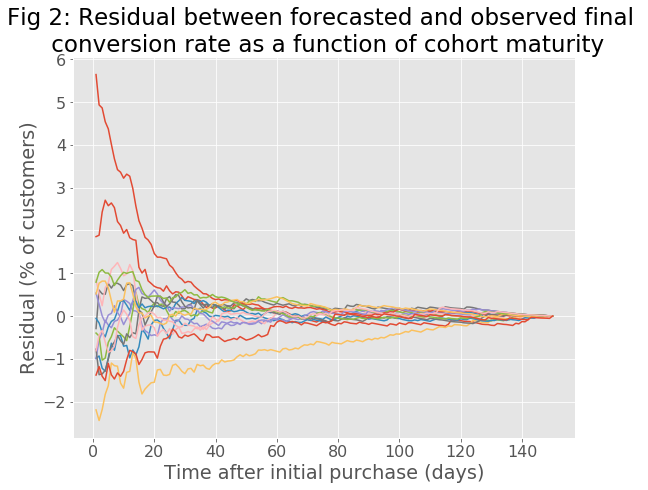

In [19]:
fig = plt.figure(figsize = (9, 7))
ax = fig.add_subplot(111)

for ch in test_surv_obs.keys():
    ax.plot(error_df['day'], error_df[ch])

plt.xlabel('Time after initial purchase (days)')
plt.ylabel('Residual (% of customers)')
plt.title('Fig 2: Residual between forecasted and observed final \n conversion rate as a function of cohort maturity')

plt.show()

As desired, the residual of the forecasts decreases toward zero with time, demonstrating that the forecasts become more accurate as the cohort matures.  The increase in forecast accuracy with time is quantified in Figure 3, which illustrates the standard deviation of the residuals of the cohorts as a funtion of time.

In [20]:
test_stdev = error_df.drop('day',axis=1).std(axis=1)

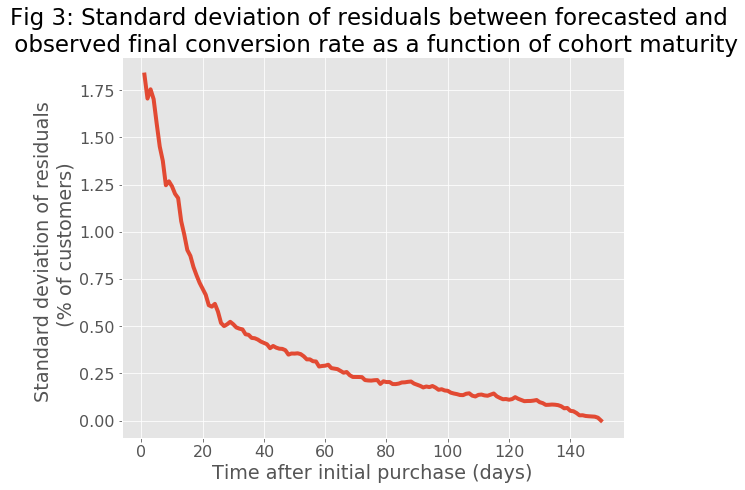

In [21]:
fig = plt.figure(figsize = (9, 7))
ax = fig.add_subplot(111)

ax.plot(error_df['day'],test_stdev,lw = 4)

plt.xlabel('Time after initial purchase (days)')
plt.ylabel('Standard deviation of residuals \n (% of customers)')
plt.title('Fig 3: Standard deviation of residuals between forecasted and \n observed final conversion rate as a function of cohort maturity')

plt.show()

As illustrated in Figure 3, forecasts for the final conversion rates become more accurate as the cohorts mature.  Among the cohorts in the testing group, the forecasts are within 3% of the final percentage of customers converted with 95% confidence by day 5, and within 1% by day 30.

### Adding features to the simple model
Lastly, I will return to the apparently outlying cohort observed in Figure 1, with a fraction of non-converted customers that is significantly higher than any other cohort in the testing group.  First, I will use the **getGroupStats** function defined in Part 1 to identify which cohort it is.

In [86]:
byCohort_df = getGroupStats(test_df,'first_purchase_date')

In the cell below, I have printed the bottom 3 cohorts in the test set sorted by final conversion rate.  The cohort making its initial purchase on May 20th is clearly the outlying cohort, with a conversion rate of only 13%, while all other cohorts have a conversion rate of around 20%.

In [91]:
byCohort_df.sort_values('conv_rate').head(3)

,first_purchase_date,num_cust,conv_rate,median_conv_time,mean_conv_time
6,5/20/2013,4363,0.134540,10.0,16.289608
4,5/18/2013,1781,0.195957,5.0,14.255014
7,5/22/2013,2956,0.200947,8.0,14.186869


In Part 1, it was noted that customers from different countries of origin convert at widely differing rates.  One might hypothesize that the May 20th cohort has a different different make up of customer nationalities, leading to a much lower conversion rate than other cohorts.  In the cell bellow, I have printed out the top 5 customer countries for the May 20th cohort, sorted by the number of customers coming from each country.

In [92]:
may20_df = test_df.groupby('first_purchase_date').get_group('5/20/2013')
may20_byCountry_df = getGroupStats(may20_df,'cust_country', n_min = 0)
may20_byCountry_df.sort_values('num_cust', ascending = False).head(5)

,cust_country,num_cust,conv_rate,median_conv_time,mean_conv_time
79,United States,2173,0.196042,9.5,14.636150
83,null,976,0.007172,14.0,18.428571
78,United Kingdom,235,0.131915,13.0,19.354839
9,Canada,170,0.158824,7.0,17.074074
2,Australia,127,0.228346,9.0,21.896552


Evidently the May 20th cohort contains many customers with a null entry for their country of origin, and these customers have a very low conversion rate, below 1%.  To see how this number of null entries compares with the rest of the cohorts in the test set, in the next cell I have repeated this calculation for all of the customers in the test set.

If we refer back to the summary stats computed by country in Part 1, we can see that the whole starting data set only has 992 null values for customer country, and 976 of those are contained in the May 20th cohort.  Further, these customers have a very low value for conversion rate, which likely results in the low conversion rate observed for the May 20th cohort.  

It is possible that these null values are indicative of a database bug, and that these customers should be excluded from the analysis, but absent any other information I will continue to assume they are valid database entries.  Instead of eliminating them, I will revise the model to take customer country into account.  In the cell below I have created another transformer class **mck_df_xform_featured**.  Unlike the simple transformer **mck_df_xform_simple**, this transformer returns a DataFrame with some customer feature columns, in addition to the **lifetime** and **converted** columns.  In this case, the additional columns are categorical variables for countries of origin, taking on 1s and 0s indicating whether a customer is from a given country.  To avoid overfitting, only the United States, United Kingdom, Canada, and Australia are encoded specifically, as they make up the bulk of the customers by a wide margin, and all other entries for customer country (including 'null') are encoded as 'Other.' 

In [95]:
class mck_df_xform_featured(base.BaseEstimator, base.RegressorMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self,mck_df):
        mck_df.loc[:,'first_purchase_date'] = mck_df.loc[:,'first_purchase_date'].apply(lambda x: pd.to_datetime(x))
        mck_df.loc[:,'cust_commit_date'] = mck_df.loc[:,'cust_commit_date'].apply(lambda x: pd.to_datetime(x))
        start_date = mck_df.loc[:,'first_purchase_date']
        end_date = mck_df.loc[:,'cust_commit_date']
        mck_df.loc[:,'lifetime'],mck_df.loc[:,'converted'] = datetimes_to_durations(start_date,end_date)
        
        country_lst = ['United States','United Kingdom','Canada','Australia']
        mck_df.loc[~mck_df['cust_country'].isin(country_lst),'cust_country'] = 'Other'
        
        X = mck_df[['lifetime','converted','cust_country']]
        X = pd.get_dummies(X, prefix = ['cust_country'], columns = ['cust_country'])
        
        return X

Below, a new scikit-learn pipeline is defined with the new transformer, and afterwards the rest of the analysis proceeds identically to that performed above with the simple model.  This demonstrates the modularity and extensibility of the workflow developed in this document.

In [96]:
mck_featured_pipeline = Pipeline([
    ('transform', mck_df_xform_featured()),
    ('regressor', mck_model(AalenAdditiveFitter(coef_penalizer=1, fit_intercept=True)))
])

In [97]:
mck_featured_pipeline.fit(train_df)

 [-----------------100%-----------------] 8000 of 8000 complete in 39.2 sec


Pipeline(steps=[('transform', mck_df_xform_featured()), ('regressor', mck_model(surv_regressor=None))])

The next cell computes the survival fractions (**test_featMdl_df**), forecasted conversion rates (**featMdl_FC_df**), and conversion rate residuals (**featMdl_Er_df**) for the featured model that uses customer countries as features, using identical code as used above with the simple model.

In [98]:
df_xformer = mck_df_xform_featured()
test_surv_mod = {}
for name,group in test_df.groupby('first_purchase_date'):
    group_xform = df_xformer.transform(group)
    test_surv_mod[str(name)[:10]] = mck_featured_pipeline.predict(group).mean(axis=1).tolist()[:150]
    
test_featMdl_df = pd.DataFrame.from_dict(test_surv_mod)
test_featMdl_df['day'] = range(1,151)

featMdl_forecast = {}
featMdl_error = {}
for ch in test_surv_obs.keys():
    featMdl_forecast[ch] = getForecast(test_obs_df[ch],test_featMdl_df[ch])
    featMdl_error[ch] = featMdl_forecast[ch]-featMdl_forecast[ch][149]

featMdl_FC_df = pd.DataFrame.from_dict(featMdl_forecast)
featMdl_FC_df['day'] = range(1,151)
featMdl_Er_df = pd.DataFrame.from_dict(featMdl_error)
featMdl_Er_df['day'] = range(1,151)

In the figure below, I have plotted the conversion rate forecast residual for the May 20th cohort based on both the simple, featureless model and the model using customer countries as features.  

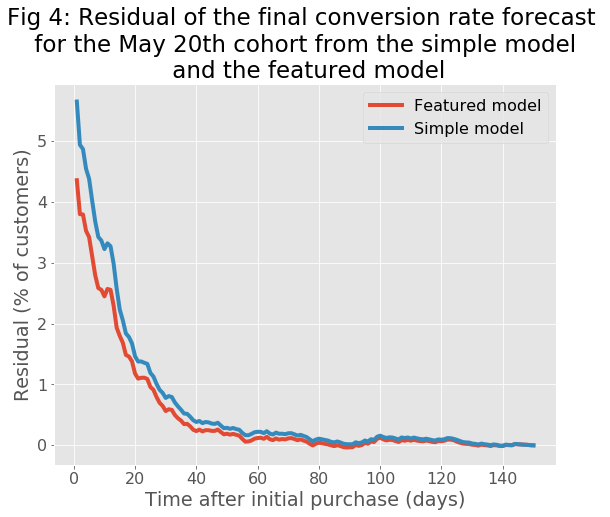

In [110]:
fig = plt.figure(figsize = (9, 7))
ax = fig.add_subplot(111)

ax.plot(featMdl_Er_df['day'], featMdl_Er_df['5/20/2013'], lw = 4, label = 'Featured model')
ax.plot(error_df['day'], error_df['5/20/2013'], lw = 4, label = 'Simple model')

plt.xlabel('Time after initial purchase (days)')
plt.ylabel('Residual (% of customers)')
plt.title('Fig 4: Residual of the final conversion rate forecast \n for the May 20th cohort from the simple model \n and the featured model')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

plt.show()

In Figure 4, we can see that including the customer countries as features in the model has improved the accuracy of the forecast for the May 20th cohort by nearly a full percentage point through the first 10 days, which is a substantial improvement.  In the next cell, I have plotted the standard deviation of the forecast residuals of all the cohorts in the test set, again using both the simple and featured models.

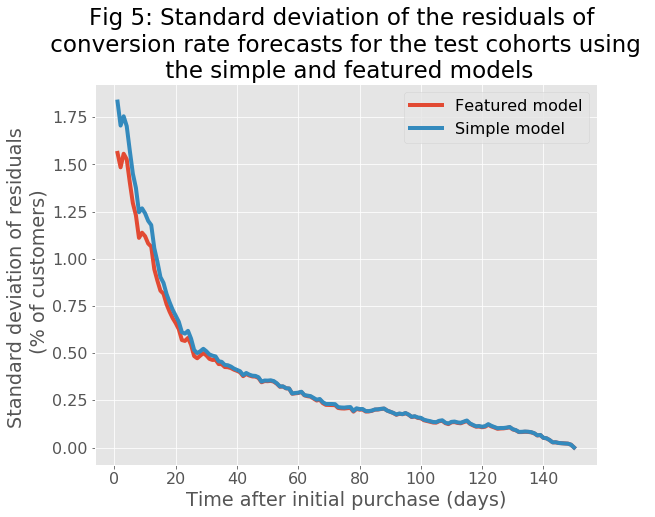

In [133]:
feat_stdev = featMdl_Er_df.drop('day',axis=1).std(axis=1)

fig = plt.figure(figsize = (9, 7))
ax = fig.add_subplot(111)

ax.plot(featMdl_Er_df['day'],feat_stdev, lw = 4, label = 'Featured model')
ax.plot(error_df['day'],test_stdev, lw = 4, label = 'Simple model')

plt.xlabel('Time after initial purchase (days)')
plt.ylabel('Standard deviation of residuals \n (% of customers)')
plt.title('Fig 5: Standard deviation of the residuals of \n conversion rate forecasts for the test cohorts using \n the simple and featured models')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

plt.show()

As illustrated in Figure 5, including the customer countries as model features has improved the overall accuracy of the conversion rate forecasts for the test set cohorts.  Should additional customer features be deemed important, they can be added to the model by creating a new transfomer class, which can then be seamlessly plugged into the workflow.